### Required libraries for EDA

In [45]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.datasets import fetch_openml

In [2]:
# Download the dataset
df_road_safety = fetch_openml(data_id=42803, as_frame=True)

In [5]:
# Extract feature matrix X & show 5 random samples
df_X = df_road_safety["frame"]

### Structure Investigation
<p>Exploring the general shape of the dataset, as well as the data types of your features.</p>

1. Number of samples and features.

2. What kind of data type each feature has, how many of them are binary, categorical or continuous.

In [6]:
#show the size of the dataset
df_X.shape

(363243, 67)

In [7]:
# Count how many times each data type is present in the dataset
pd.value_counts(df_X.dtypes)

float64    61
object      6
dtype: int64

In [8]:
# Lets take a closer look at non-numerical observations
df_X.select_dtypes(exclude="number").head()

,Accident_Index,Sex_of_Driver,Date,Time,Local_Authority_(Highway),LSOA_of_Accident_Location
0,201501BS70001,1.0,12/01/2015,18:45,E09000020,E01002825
1,201501BS70002,1.0,12/01/2015,07:50,E09000020,E01002820
2,201501BS70004,1.0,12/01/2015,18:08,E09000020,E01002833
3,201501BS70005,1.0,13/01/2015,07:40,E09000020,E01002874
4,201501BS70008,1.0,09/01/2015,07:30,E09000020,E01002814


<p>Even though "Sex_of_Driver" is a numerical feature, it somehow was stored in as non-numerical data, which could indicate typo in data recording.</p>

In [9]:
# Changing the data type of 'Sex_of_Driver'
df_X["Sex_of_Driver"] = df_X["Sex_of_Driver"].astype("float")

In [11]:
# How many unique values each non-numerical feature has ?
# And with which frequency most prominent value is present ?
df_X.describe(exclude="number")

,Accident_Index,Date,Time,Local_Authority_(Highway),LSOA_of_Accident_Location
count,363243,319866,319822,319866,298758
unique,140056,365,1439,204,25979
top,201543P296025,14/02/2015,17:30,E10000017,E01028497
freq,1332,2144,2972,8457,1456


In [12]:
# Let's check out the numerical features
# Number of unique values
unique_values = df_X.select_dtypes(include="number").nunique().sort_values()

<AxesSubplot:title={'center':'Unique Values Per Feature'}>

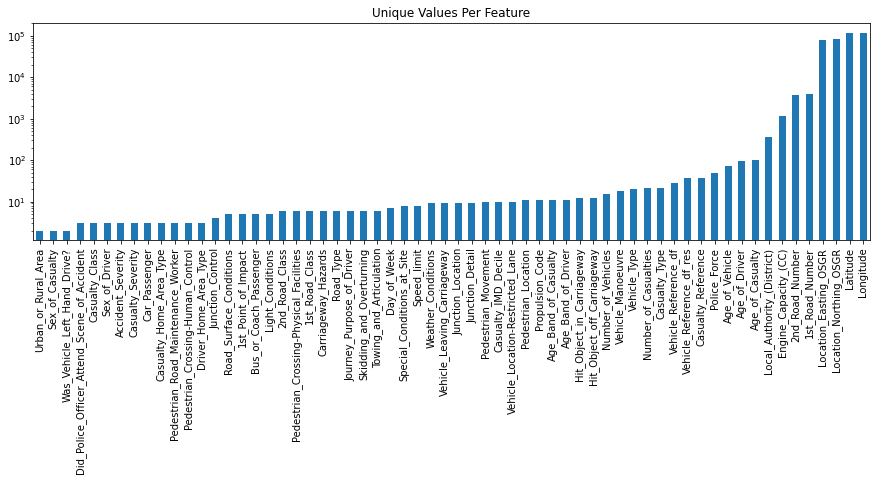

In [15]:
# Plot info with y-axis in log-scale
unique_values.plot.bar(logy=True, 
                       figsize=(15,4),
                       title="Unique Values Per Feature")

### Quality Investigation
<p>Get a feeling for the general quality of the dataset, with regards to duplicates, missing value and unwanted entries.</p>

#### Duplicates
<p>Entries that represent same sample point multiple times.</p>

In [16]:
# Number of duplicates while ignoring the index feature
n_duplicates = df_X.drop(labels=["Accident_Index"],
                         axis=1).duplicated().sum()
print(f"You seem to have {n_duplicates} duplicates in your database.")

You seem to have 22 duplicates in your database.


In [17]:
# Extract col names of all features, except 'Accident_Index'
cols_to_consider = df_X.drop(labels=["Accident_Index"],
                             axis=1).columns

In [18]:
# Drop duplicates based on 'cols_to_consider'
df_X = df_X.drop_duplicates(subset=cols_to_consider)
df_X.shape

(363221, 67)

#### Missing Values
<p>Detect samples or features with lot of missing values.</p>

Text(0, 0.5, 'Sample Number')

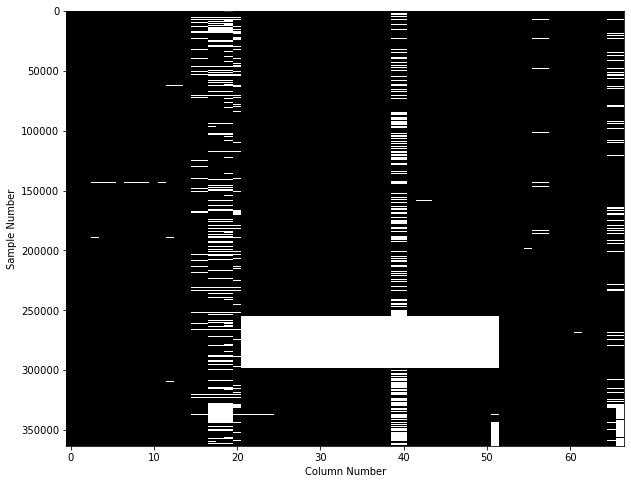

In [19]:
# Per Sample : df_X.isna()
plt.figure(figsize=(10,8))
plt.imshow(df_X.isna(),
           aspect="auto",
           interpolation="nearest",
           cmap="gray")
plt.xlabel("Column Number")
plt.ylabel("Sample Number")

<p>The above fig shows 360K individual samples on y-axis ans 67 features on x-axis containing a missing values.</p>

In [22]:
!pip install missingno

In [23]:
# Even better method would be to use "missingno" lib 
import missingno as msno

<AxesSubplot:>

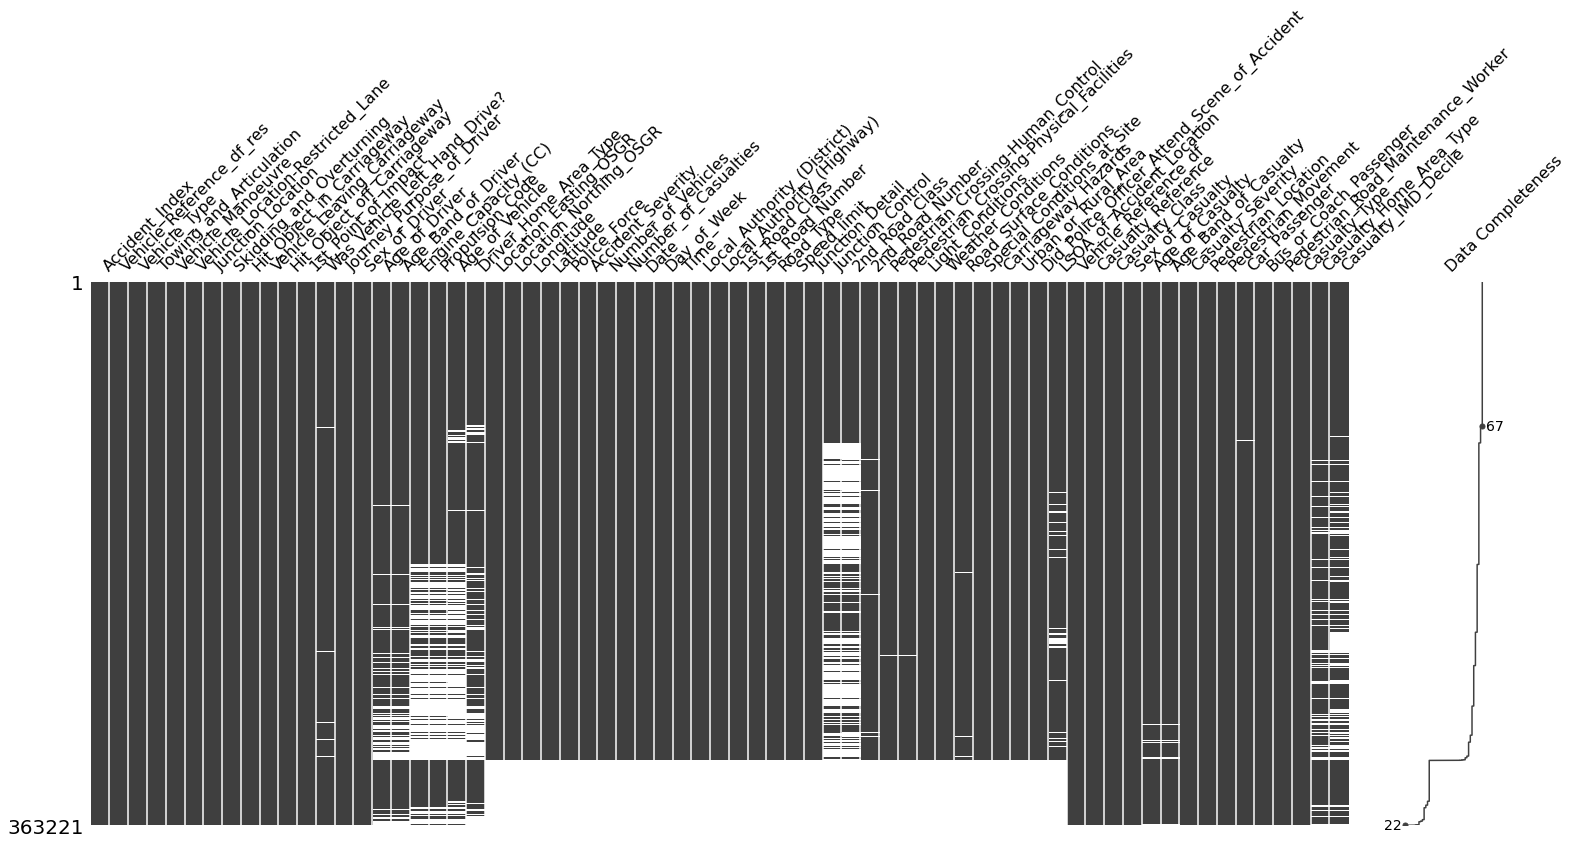

In [24]:
msno.matrix(df_X, labels=True, sort="descending")

<p>From the above plot, we can notice huge gap, caused by some samples where more than 50% feature values are missing. For those samples, filling the missing values with some replacement values is probably not a good idea, so hence, droppiing samples that have more than 20% missing values sounds about right,inspired by the info from the "Data Completeness" column on the right side of the above figure.</p>

In [25]:
df_X = df_X.dropna(thresh=df_X.shape[1] * 0.80,
                   axis=0).reset_index(drop=True)

In [26]:
df_X.shape

(319790, 67)

#### Unwanted entries & recording errors
<p>Samples that shouldn't be there in the first place.</p>

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplo

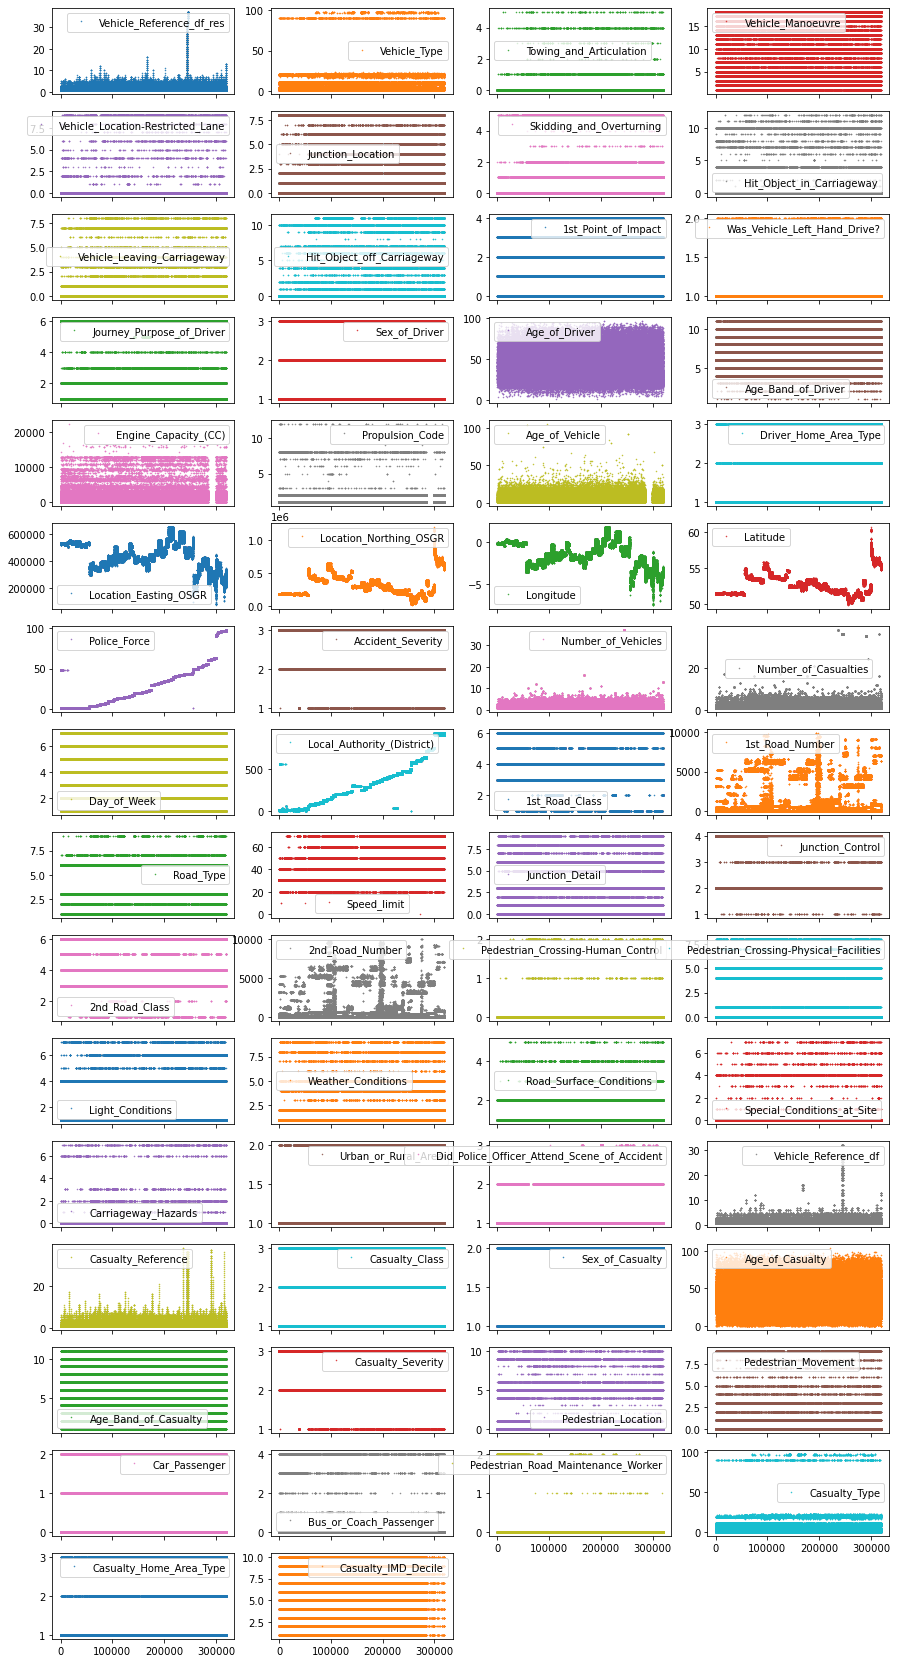

In [27]:
# Numerical Features

# lw=0: lw stands for line width
# marker=".": Instead of lines, we tell the plot to use . as markers for each data point
# subplots=True: subplots tells pandas to plot each feature in a separate subplot
# layout=(-1, 4): This parameter tells pandas how many rows and columns to use for the subplots. The -1 means “as many as needed”, while the 2 means to use 2 columns per row.
# figsize=(15, 30)
df_X.plot(lw=0, marker=".", subplots=True, layout=(-1, 4),
          figsize=(15, 30), markersize=1)

<p>Each point in the figure above is a sample(i.e. a row) in our dataset and each subplot represents a different feature. The y-axis shows the feature value, while x-axis is sample index.</p>

In [28]:
# Non-numerical feature

# How many unique values each of these non-numerical features contain
# How often their most frequent category is represented

# Extarct descriptive properties of non-numerical features
df_X.describe(exclude=["number", "datetime"])

,Accident_Index,Date,Time,Local_Authority_(Highway),LSOA_of_Accident_Location
count,319790,319790,319746,319790,298693
unique,123645,365,1439,204,25977
top,201543P296025,14/02/2015,17:30,E10000017,E01028497
freq,1332,2144,2969,8457,1456


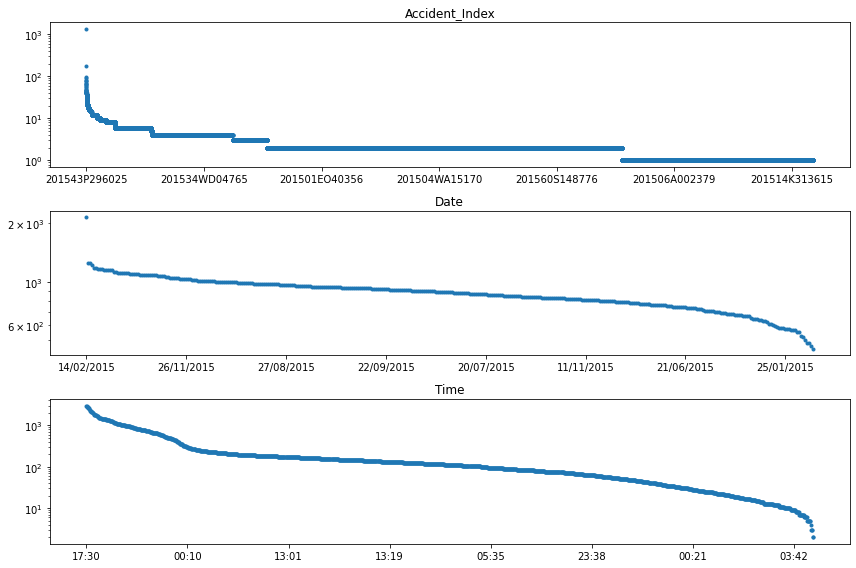

In [29]:
# Loop through all non-numerical features & plot for each of
# them the number of occurences per unique value

# Create fig object with 3 subplots
fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(12,8))

# Identify non-numerical features
df_non_numerical = df_X.select_dtypes(exclude=["number", "datetime"])

# Loop through features & put each subplot on a matplotlib axis object
for col, ax in zip(df_non_numerical.columns, axes.ravel()):
    
    # Selects one single feature & counts number of occurences per unique value
    df_non_numerical[col].value_counts().plot(
    
        # Plots this info in a fig with log-scaled y-axis
        logy=True, title=col, lw=0, marker=".", ax=ax
    )

plt.tight_layout()

<p>From the above plots we can see that the most frequent accident (i.e. Accident_Index) had more than 100 people involved. Digging deeper(i.e. looking at the individual features of this accident), one can identify that this accident happend on Feb 24th, 2015 at 11:55 in Cardiff UK. A quick internet search reveals that this entry corresponds to non-lethal accident including a minibus full of pensioners.</p>

In [31]:
# Collect entry values of 10 most frequent accidents
accidents_ids = df_non_numerical["Accident_Index"].value_counts().head(10).index

# Removes accidents from the 'accident_ids' list
df_X = df_X[~df_X["Accident_Index"].isin(accidents_ids)]
df_X.shape

(317665, 67)

### Content Investigation
<p>Once the structure and quality of the dataset is understood, we can go ahead and perform a more in-depth exploration on the feature values and look at how different features relate to each other.</p>

#### Feature Distribution
<p>To better understand the content of the data, and furthermore help guied EDA and provide useful info with regards to data cleaning and feature transformation using histogram plots.</p>

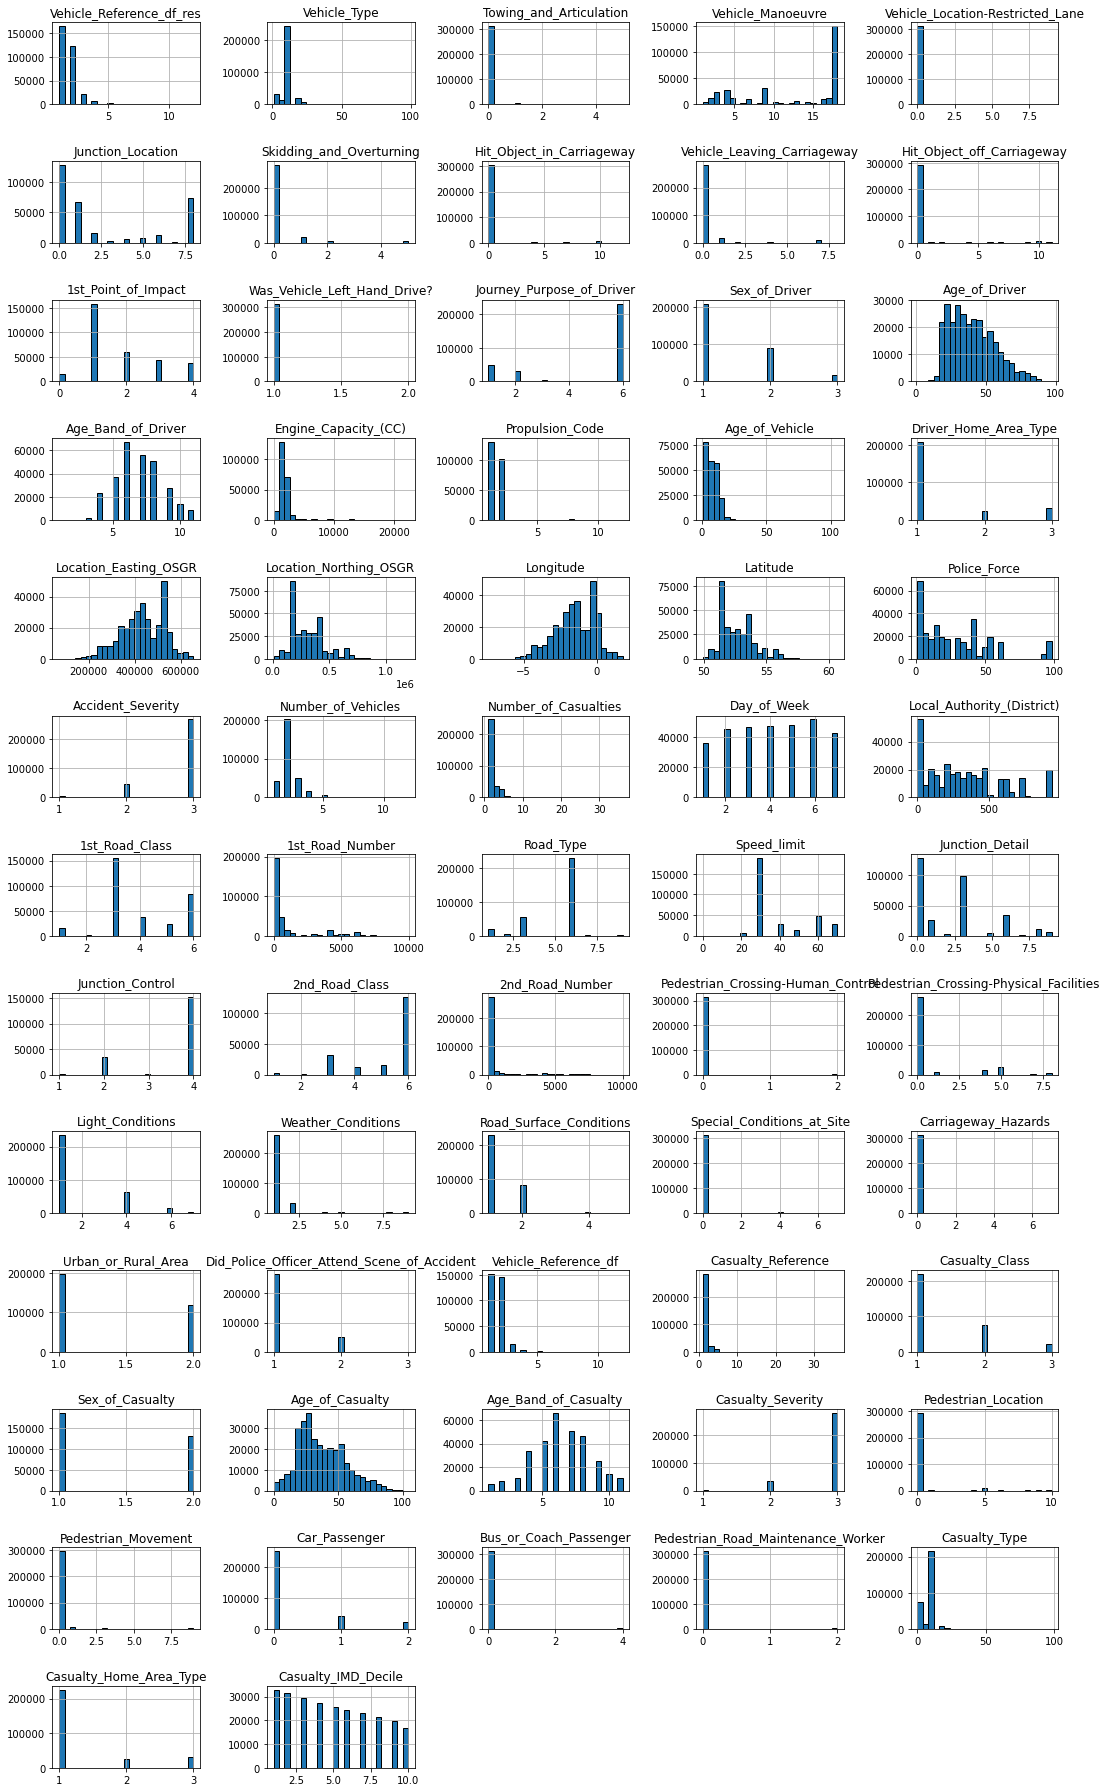

In [32]:
# Plot histogram for each numerical feature in a separate subplot
df_X.hist(bins=25,
          figsize=(15,25),
          layout=(-1, 5),
          edgecolor="black")
plt.tight_layout()

> **Note:** Some features like "Towing_And_Articulation" or "Was_Vehicle_Left_Hand_Drive" mostly contain entries of just one category. Using the .mode() function, one could for example extract the ratio of the most frequent entry for each feature & visaulize that information.

In [34]:
# Collects for each feature the most frequent entry
most_frequent_entry = df_X.mode()

In [35]:
# Checks for each entry if it contains the most frequent entry 
df_freq = df_X.eq(most_frequent_entry.values, axis=1)

In [36]:
# Computes the mean of the 'is_most_frequent' occurence
df_freq = df_freq.mean().sort_values(ascending=False)

In [37]:
# Show the 5 top features with the highest ratio
# of singular value content
display(df_freq.head())

Pedestrian_Crossing-Human_Control    0.995259
Was_Vehicle_Left_Hand_Drive?         0.990137
Carriageway_Hazards                  0.983646
Towing_and_Articulation              0.983221
Vehicle_Location-Restricted_Lane     0.982088
dtype: float64

<AxesSubplot:>

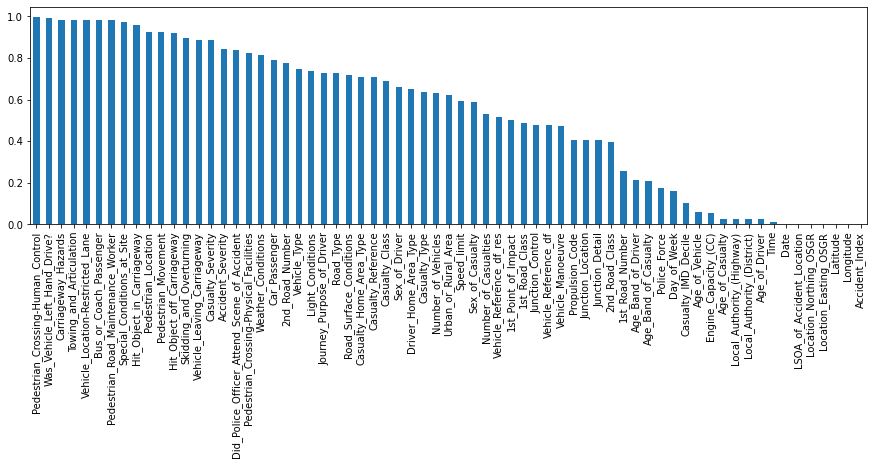

In [38]:
# Visualize the 'df_freq' table
df_freq.plot.bar(figsize=(15,4))

#### Feature Patterns
<p>Can we identify particular patterns within a feature that will help us to decide if some entries need to be dropped or modified?</p>
<p>Can we identify particular relationships between features that will help us to better understand our dataset?</p>

array([[<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

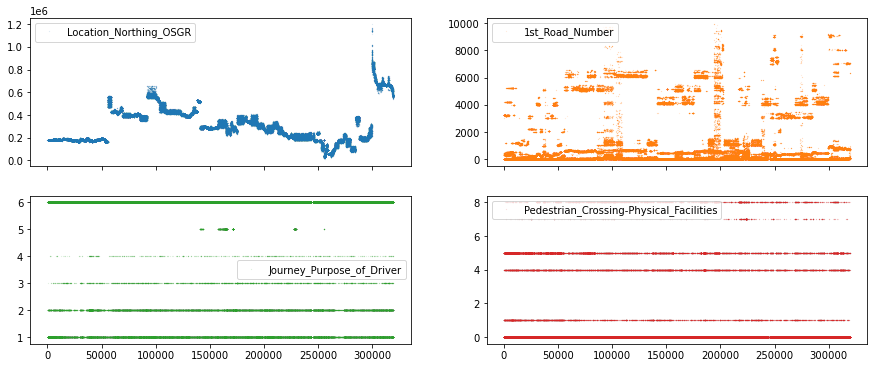

In [39]:
df_X[["Location_Northing_OSGR", "1st_Road_Number",
      "Journey_Purpose_of_Driver", "Pedestrian_Crossing-Physical_Facilities"]].plot(
    lw=0, marker=".", subplots=True, layout=(-1, 2), markersize=0.1, figsize=(15, 6))

<p>The top consists of features with continuous values while the bottom row has features with discrete values.</p>

#### Features with less than 25 unique features be treated as **discrete** or **ordinal** while other features as **continuous**

In [42]:
# Create mask to identify numerical features with more or less
# than 25 unique features
cols_continuous = df_X.select_dtypes(include="number").nunique() >= 25

#### Continuous Features

In [43]:
# Create a new df which only contains the continous features
df_continuous = df_X[cols_continuous[cols_continuous].index]
df_continuous.shape

(317665, 13)

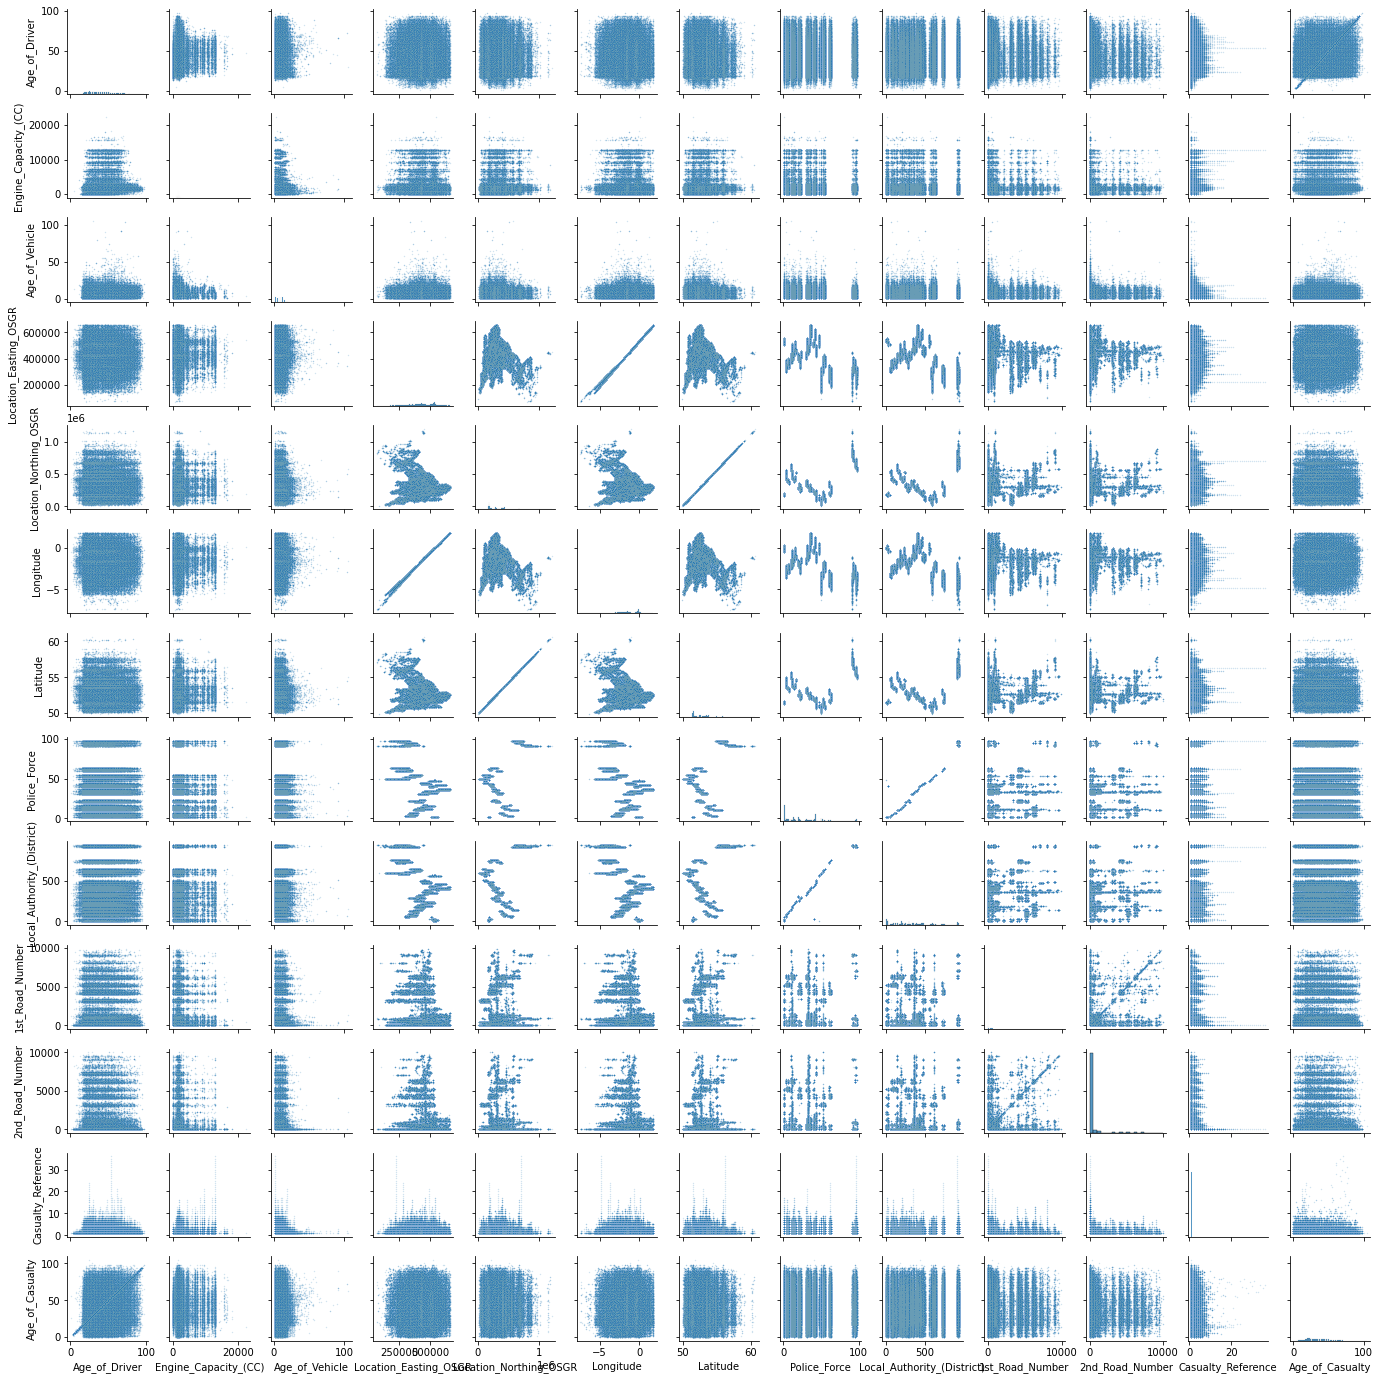

In [47]:
sns.pairplot(df_continuous,
             height=1.5,
            plot_kws={"s":2, 
                      "alpha":0.2})

<p>From the above plot there seems to be a strange relationship between few features in top left corner : Location_Easting_OSGR, Longitude, Location_Northing_OSGR and Latitude seems to have a very strong linear relationship.</p>

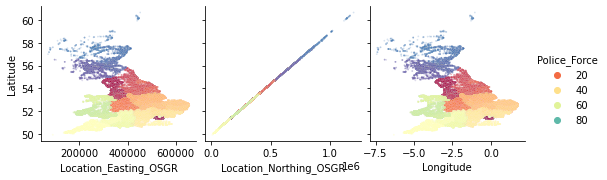

In [48]:
sns.pairplot(
                df_X,
                plot_kws={"s":3, "alpha":0.2},
                hue="Police_Force",
                palette="Spectral",
                x_vars=["Location_Easting_OSGR",
                        "Location_Northing_OSGR",
                        "Longitude"],
                y_vars="Latitude"
            )

<p>More preferrably, since these features contain geographic information, a more in-depth EDA with geolocation would be good idea.</p>

#### Discrete & Ordinal Features

In [49]:
# Create a new df which doesn't contain numerical continuous features
df_discrete = df_X[cols_continuous[~cols_continuous].index]
df_discrete.shape

(317665, 49)

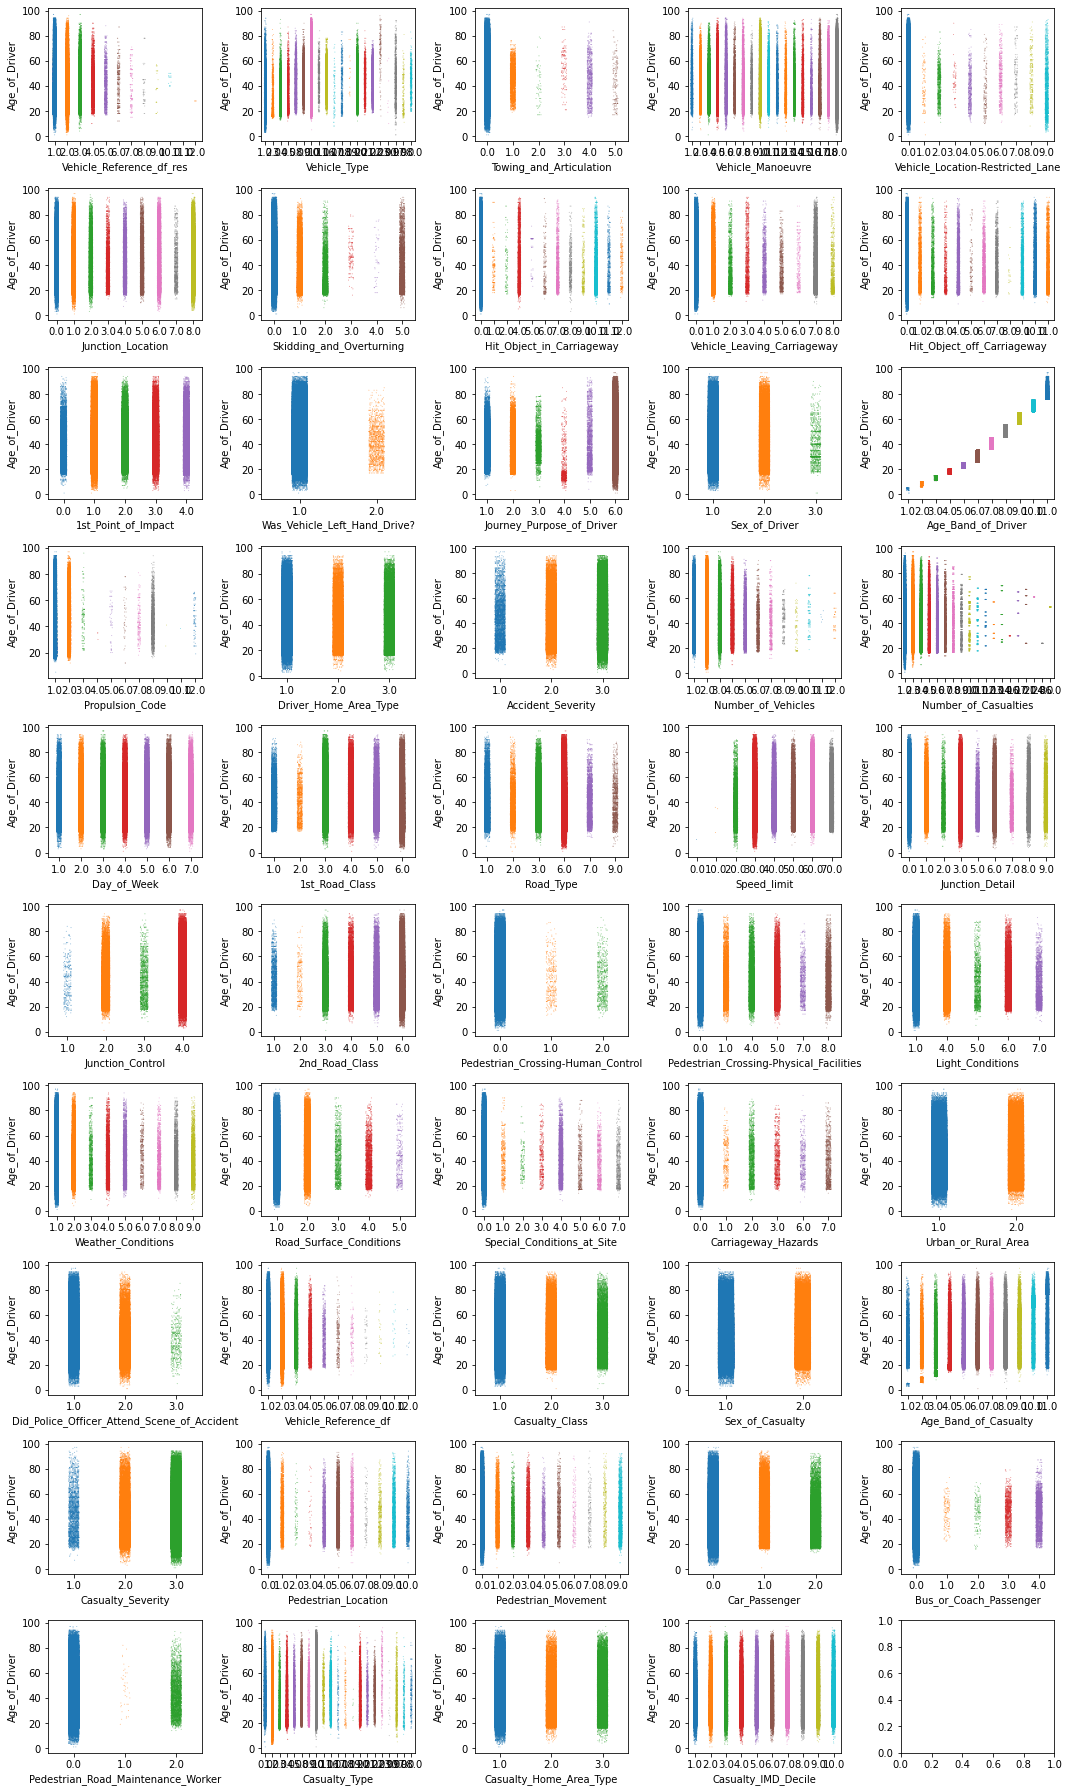

In [50]:
# Let's investigate all of the discrete/ordinal features

# Establish num of cols & rows needed to plot all features
n_cols = 5
n_elements = len(df_discrete.columns)
n_rows = np.ceil(n_elements / n_cols).astype("int")

# Specify y_value to spread data (ideally a continuous feature)
y_value = df_X["Age_of_Driver"]

# Create figure object with as many rows & cols as needed
fig, axes = plt.subplots(ncols=n_cols,
                         nrows = n_rows,
                         figsize=(15, n_rows * 2.5))

# Loop through features & put each subplot on a matplotlib axis object
for col, ax in zip(df_discrete.columns, axes.ravel()):
    sns.stripplot(data=df_X,
                  x=col,
                  y=y_value,
                  ax=ax,
                  palette="tab10",
                  size=1,
                 alpha=0.5)

plt.tight_layout()

<p>At this moment, going to pick 6 features where the values appear to have some particular pattern or where some categories seem to be much less frequent than other to make EDA much simplified.</p>

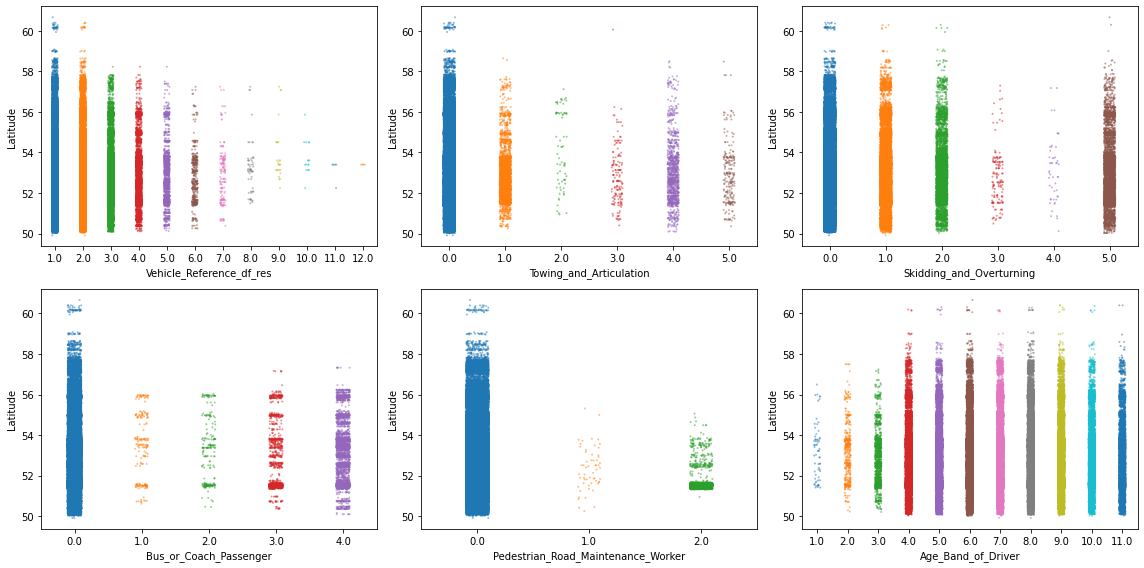

In [51]:
# Specify features of interest
selected_features = ["Vehicle_Reference_df_res", "Towing_and_Articulation",
                     "Skidding_and_Overturning", "Bus_or_Coach_Passenger",
                     "Pedestrian_Road_Maintenance_Worker", "Age_Band_of_Driver"]

# Create a fig with 3x2 subplots
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(16,8))

# Loop through these features and plot entries from each feature 
# against 'Latitude'
for col, ax in zip(selected_features, axes.ravel()):
    sns.stripplot(data=df_X,
                  x=col,
                  y=df_X["Latitude"],
                  ax=ax,
                  palette="tab10",
                  size=2, 
                  alpha=0.5)

plt.tight_layout()

<p>In the above plot there seems to be a high density of points in some of the plots at 52nd latitude. Hence, let's take a closer look with appropriate plot like <b>violineplot</b> or <b>boxplot</b> and separate each visualization by Urban_or_Rural_Area.</p>

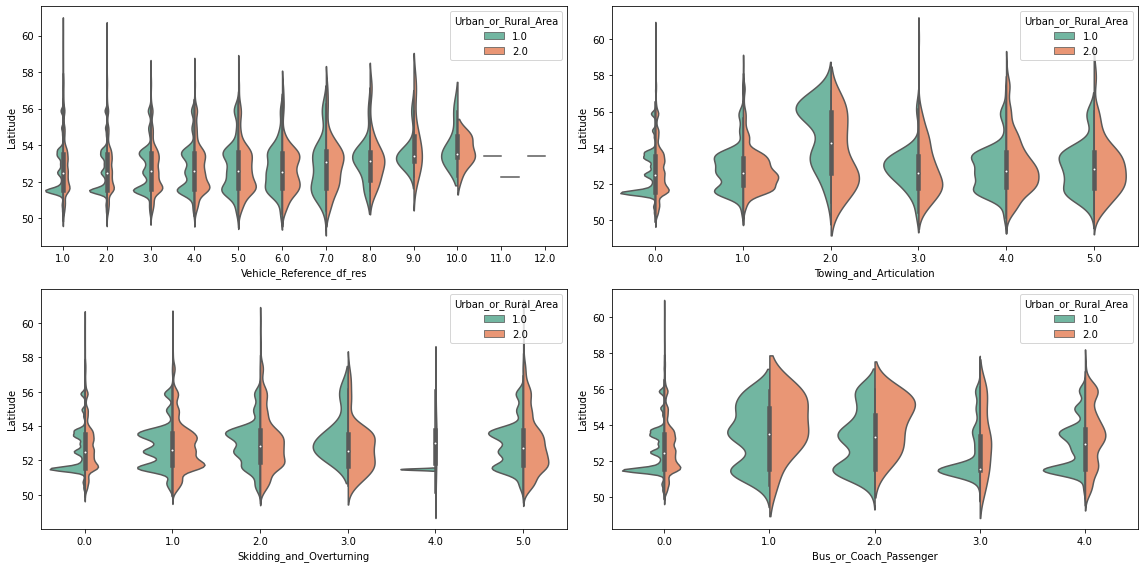

In [53]:
# Create a fig with 3x2 subplots
fig, axes = plt.subplots(ncols=2,
                         nrows=2,
                         figsize=(16,8))

# Loop through these features & plot entries from each
# feature against 'Latitude'
for col, ax in zip(selected_features, axes.ravel()):
    sns.violinplot(data=df_X,
                   x=col,
                   y=df_X["Latitude"],
                   palette="Set2",
                   split=True,
                   hue="Urban_or_Rural_Area",
                   ax=ax)
    
plt.tight_layout()

<p>From the above plot some values on features are more frequent in urban, than in rural areas and as suspected there seems o be a high density peak at latitude 51.5. This is very likely due to the more densely populated region around London (at 51.5074°)

#### Feature Relationships
<p><b>Pearson Correlation</b> evaluates linear relationship between two continuous variables.</p>
<p><b>Spearman Correlation</b> evaluates monotonic relationship based on the ranked values for each feature.</p>

In [54]:
# Computes feature correlation
df_corr = df_X.corr(method="pearson")

<AxesSubplot:>

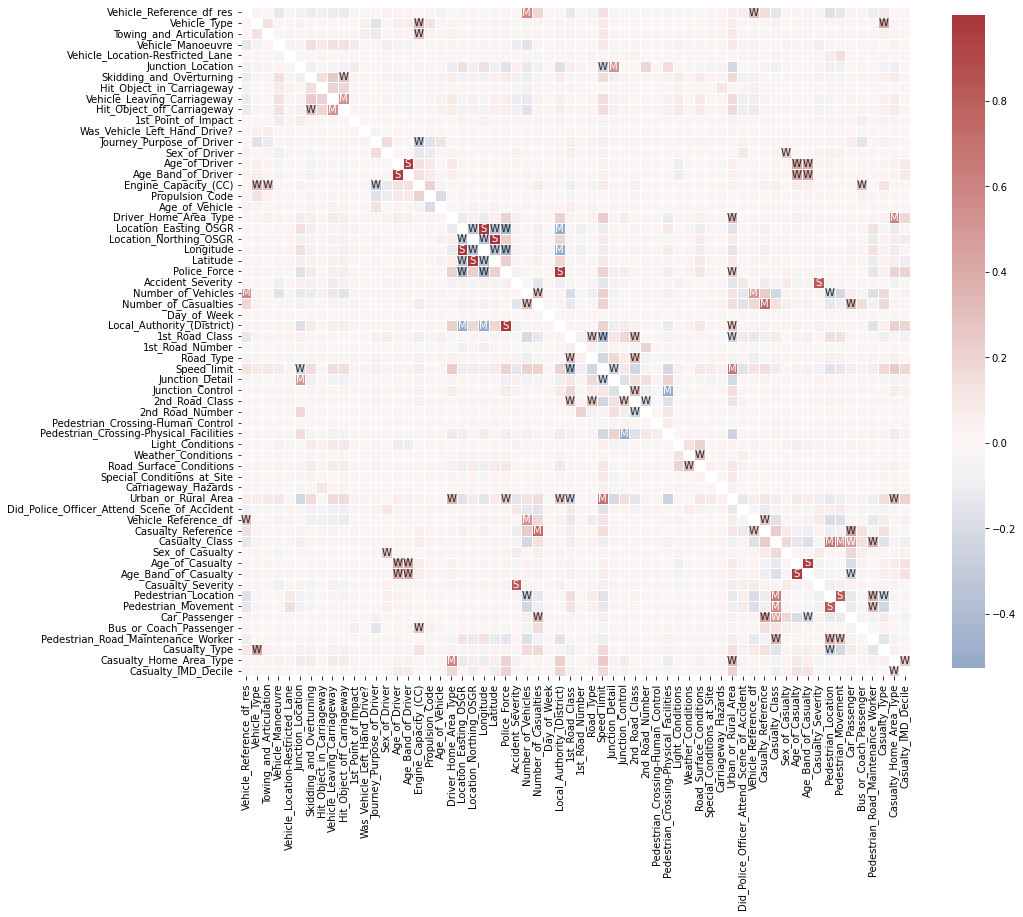

In [55]:
# Create labels for the corr matrix
labels = np.where(np.abs(df_corr) > 0.75, "S",
                  np.where(np.abs(df_corr)>0.5, "M",
                           np.where(np.abs(df_corr)>0.25, "W", "")))

# Plot corr matrix
plt.figure(figsize=(15, 15))
sns.heatmap(df_corr, mask=np.eye(len(df_corr)), square=True,
            center=0, annot=labels, fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink":0.8})

<p>From the above plot one can notice very strong correlations between some of the features.</p>

In [56]:
# Ordering of all of these different correlations

# Create a mask to remove th diagonal & upper triangle
lower_triangle_mask = np.tril(np.ones(df_corr.shape), k=1).astype("bool")

# Stack all corr, after applying the mask
df_corr_stacked = df_corr.where(lower_triangle_mask).stack().sort_values()

# Showing the lowest & highest corr in the correlation matrix
display(df_corr_stacked)

Pedestrian_Crossing-Physical_Facilities  Junction_Control        -0.526258
Local_Authority_(District)               Longitude               -0.509343
                                         Location_Easting_OSGR   -0.502919
Police_Force                             Longitude               -0.471327
                                         Location_Easting_OSGR   -0.461112
                                                                    ...   
Junction_Detail                          Junction_Detail          1.000000
Speed_limit                              Speed_limit              1.000000
Road_Type                                Road_Type                1.000000
1st_Road_Class                           1st_Road_Class           1.000000
Casualty_IMD_Decile                      Casualty_IMD_Decile      1.000000
Length: 2014, dtype: float64

<p>Furthermore, it would good idea to few additional steps like outlier detection and removal, feature engineering and transformation in future.</p>